In [1]:
import argparse
import os
import numpy as np
import cv2
from numpy.linalg import eig
from sklearn import neighbors
import matplotlib.pyplot as plt

In [2]:
def create_data(path):
    x=[]
    y=[]
    for person in os.listdir(path):
        label = int(person[1:])
        for file in os.listdir(path + '/' + person):
            img = cv2.imread(path + '/' + person + '/' + file, 0)
            x.append(np.array(img).flatten())
            y.append(label)
    x = np.stack(x, axis=1)
    return x, y

In [3]:
def pca(train, test, dim):
    mean = np.mean(train, axis=0)
    train = train - mean
    test = test - mean
    A = train - mean
    C =  1/A.shape[1] * np.dot(A.T,A)

    eigval, eigvec = eig(C)
    eigvec = np.dot(A,eigvec)
    eigvec = eigvec/np.linalg.norm(eigvec, axis=0)
    eigval = (A.shape[0]/A.shape[1])*eigval

    idx = eigval.argsort()[::-1]
    eigval = eigval[idx]
    eigvec = eigvec[:,idx]

    eigvec = eigvec[:,:int(dim)]

    train = np.dot(train.T, eigvec)
    test = np.dot(test.T, eigvec)

    return train, test

In [4]:
def lda(x_train, y_train, test, dim):

    n_features = x_train.shape[1]
    class_labels = np.unique(y_train)
    
    mean = np.mean(x_train, axis=0)
    Sb = np.zeros((n_features,n_features))
    Sw = np.zeros((n_features,n_features))

    for l in class_labels:
        A_class = x_train[y_train == l]
        mean_class = A_class.mean(axis = 0)
        n_c = A_class.shape[0]

        Sb += n_c * (mean_class -mean) *(mean_class-mean).T
        Sw += np.dot((A_class-mean_class).T, (A_class-mean_class))
   
    A = np.linalg.inv(Sw).dot(Sb)
    eigval, eigvec = np.linalg.eigh(A)
    idx = eigval.argsort()[::-1]
    eigval = eigval[idx]
    eigvec = eigvec[:,idx]
    eigvec = eigvec[:,:int(dim)]

    x_train = np.dot(x_train, eigvec)
    test = np.dot(test, eigvec)

    return x_train, test

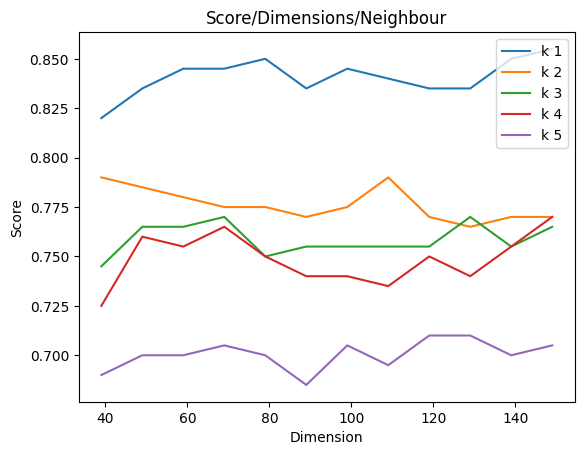

In [7]:
x_train, y_train = create_data('train')
x_test, y_test = create_data('test')
best_score=0
best_d=0
best_k=0
for k in range(1,6):
    ds=[]
    scores=[]
    for d in range(39, 159, 10):
        train_pca, test_pca = pca(x_train, x_test, 200)
        train, test = lda(train_pca, y_train, test_pca, d)
        clf = neighbors.KNeighborsClassifier(n_neighbors=k)
        clf.fit(train, y_train)
        score = clf.score(test, y_test)
        if score > best_score:
            best_score=score
            best_d = d
            best_k = k
        ds.append(d)
        scores.append(score)
    plt.plot(ds, scores, label= "k " + str(k))

plt.xlabel('Dimension')
plt.ylabel('Score')
plt.title('Score/Dimensions/Neighbour')
plt.legend()
plt.show()

In [8]:
print("best params -> " + "dimension: " + str(best_d) +  ", neighbours: " + str(best_k) + ", score: " + str(best_score))

best params -> dimension: 149, neighbours: 1, score: 0.855
